In [3]:
%reload_ext autoreload
%autoreload 2

In [6]:
from datasets import DatasetDict
from lightning_training import *
from data_process.tokenizers import FullMoveTokenizerNoEOS

import torch
import matplotlib.pyplot as plt
from nanoGPT.model import GPTConfig
from lightning_training import *

In [4]:
dataset = DatasetDict.load_from_disk("./data/huggingface_datasets/elo_bins/split/elo_1500")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 6000000
    })
    valid: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 100000
    })
    test: Dataset({
        features: ['index', 'id', 'date', 'white_elo', 'black_elo', 'result', 'ply', 'ply_30s', 'piece_uci'],
        num_rows: 100000
    })
})

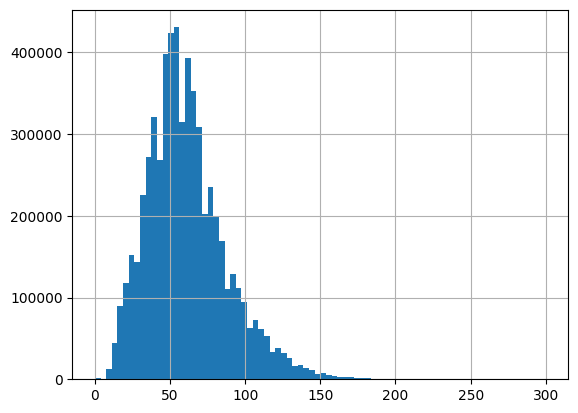

In [6]:
train_df = dataset['train'].to_pandas()
lengths = train_df.apply(lambda row: row['ply_30s'] if row['ply_30s'] != -1 else row['ply'], axis=1)
lengths.hist(bins=80)
plt.show()

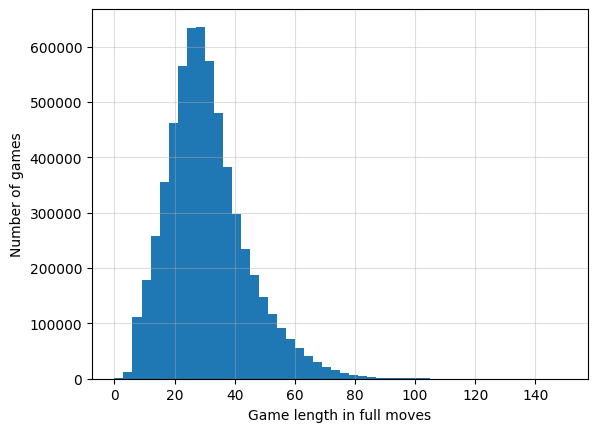

In [7]:
lengths_2 = lengths//2
lengths_2.hist(bins=50)
plt.grid(alpha=0.4)
plt.xlabel('Game length in full moves')
plt.ylabel('Number of games')
plt.show()

In [20]:
len(lengths)

6000000

In [42]:
len(lengths_2[lengths_2 > 80]) / len(lengths_2) * 100

0.26533333333333337

In [6]:
tokenizer = FullMoveTokenizerNoEOS()

model_config = GPTConfig(
    block_size=301,
    vocab_size=len(tokenizer.vocab),
    n_layer=8,
    n_head=8,
    n_embd=512,
    bias=False,
)

model_config = GPTConfig(
    block_size=301,
    vocab_size=len(tokenizer.vocab),
    n_layer=4,
    n_head=4,
    n_embd=256,
    bias=False,
)


pl_model = LightningGPT(model_config)


number of parameters: 4.19M


In [7]:
data_module = DataModuleMaiaTraining(dataset, num_workers=8, batch_size=64, max_game_length=300)

In [8]:
tensorboard_logger = pl.loggers.TensorBoardLogger(save_dir="./lightning_logs/rating_bins/", name=f"elo_1900")
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=1, mode="min")

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=10,
    callbacks=[pl.callbacks.RichProgressBar(), early_stopping],
    # logger=tensorboard_logger,
    # precision="bf16-mixed",
    # default_root_dir=
    # fast_dev_run=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
checkpoint_elo_1100 = "./lightning_logs/rating_bins/elo_1100/version_3/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1200 = "./lightning_logs/rating_bins/elo_1200/version_0/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1300 = "./lightning_logs/rating_bins/elo_1300/version_3/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1400 = "./lightning_logs/rating_bins/elo_1400/version_2/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1500 = "./lightning_logs/rating_bins/elo_1500/version_1/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1600 = "./lightning_logs/rating_bins/elo_1600/version_5/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1700 = "./lightning_logs/rating_bins/elo_1700/version_1/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1800 = "./lightning_logs/rating_bins/elo_1800/version_0/checkpoints/epoch=9-step=937500.ckpt"
checkpoint_elo_1900 = "./lightning_logs/rating_bins/elo_1900/version_2/checkpoints/epoch=9-step=937500.ckpt"

In [11]:
pl_model = LightningGPT(model_config)
# pl_model = LightningGPT.load_from_checkpoint(checkpoint_elo_1900, config=model_config)

number of parameters: 4.19M


In [12]:
torch.set_float32_matmul_precision("high")

In [ ]:
# trainer.fit(
#     model=pl_model,
#     datamodule=data_module,
#     # ckpt_path=checkpoint_elo_1900
# )

In [10]:
checkpoints = {
    "elo_1100": checkpoint_elo_1100,
    "elo_1200": checkpoint_elo_1200,
    "elo_1300": checkpoint_elo_1300,
    "elo_1400": checkpoint_elo_1400,
    "elo_1500": checkpoint_elo_1500,
    "elo_1600": checkpoint_elo_1600,
    "elo_1700": checkpoint_elo_1700,
    "elo_1800": checkpoint_elo_1800,
    "elo_1900": checkpoint_elo_1900,
}

dataset_dict_prefix = "./data/huggingface_datasets/elo_bins/split/elo_"


data_modules = {
    f"bin_{elo}": DataModuleMaiaTraining(DatasetDict.load_from_disk(f"{dataset_dict_prefix}{elo}"), num_workers=8, batch_size=64, max_game_length=300)
    for elo in range(1100, 2000, 100)
}

In [11]:
trainer = pl.Trainer(
    accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
scores = {}

for elo in range(1100, 2000, 100):
    checkpoint = checkpoints[f"elo_{elo}"]
    pl_model = LightningGPT.load_from_checkpoint(checkpoint, config=model_config)

    model_scores = {}

    for elo_key, data_module in data_modules.items():
        score = trainer.test(model=pl_model, datamodule=data_module, verbose=False)
        model_scores[elo_key] = score[0]

    scores[f"model_{elo}"] = model_scores

In [ ]:
accuracies = {}

ply = [f"{i+10}" for i in range(0, 250, 10)]

for elo in range(1100, 2000, 100):
    checkpoint = checkpoints[f"elo_{elo}"]
    pl_model = LightningGPT.load_from_checkpoint(checkpoint, config=model_config)

    data_module = data_modules[f"bin_{elo}"]

    score = trainer.test(model=pl_model, datamodule=data_module, verbose=False)
    acc = [score[0][f"test_acc_ply_{i+1}-{i+10}"] for i in range(0, 250, 10)]

    accuracies[f"model_{elo}"] = acc


In [4]:
accuracies = torch.load("./lightning_logs/rating_bins/acc_ply.pt")

['1-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100', '101-105', '106-110', '111-115', '116-120', '121-125']


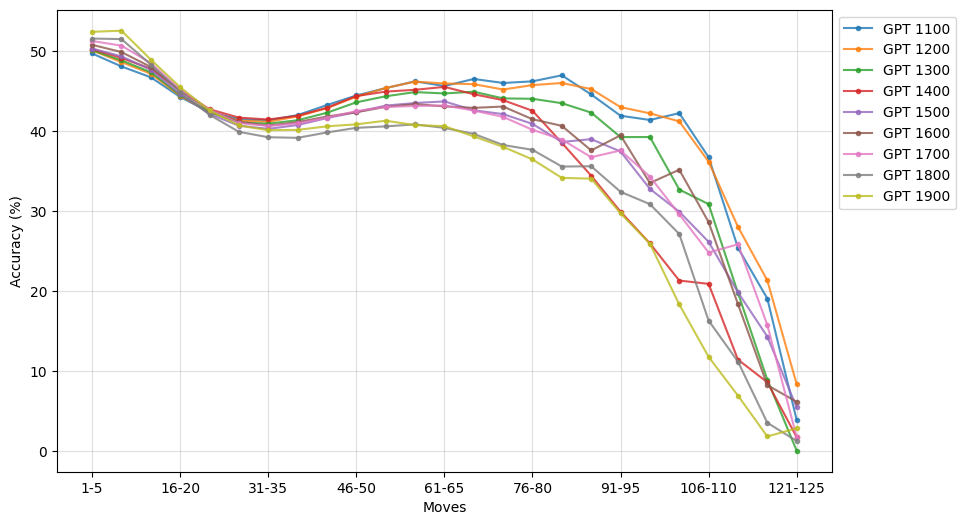

In [8]:
moves = list(range(5, 126, 5))

moves = [f"{i+1}-{i+5}" for i in range(0, 125, 5)]

print(moves)

plt.figure(figsize=(10, 6))


for name, acc in accuracies.items():
    acc = [a * 100 for a in acc]

    plt.plot(moves, acc, label=f"GPT {name[-4:]}", marker='o', linestyle='-', alpha=0.8, markersize=3)


show_x_labels = [f"{i+1}-{i+5}" for i in range(0, 125, 5) if i % 15 == 0]
show_x_positions = [moves.index(label) for label in show_x_labels]

plt.xticks(show_x_positions, show_x_labels)

plt.xlabel("Moves")
plt.ylabel("Accuracy (%)")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.show()

In [9]:
scores = torch.load("./lightning_logs/rating_bins/scores.pt")
# scores

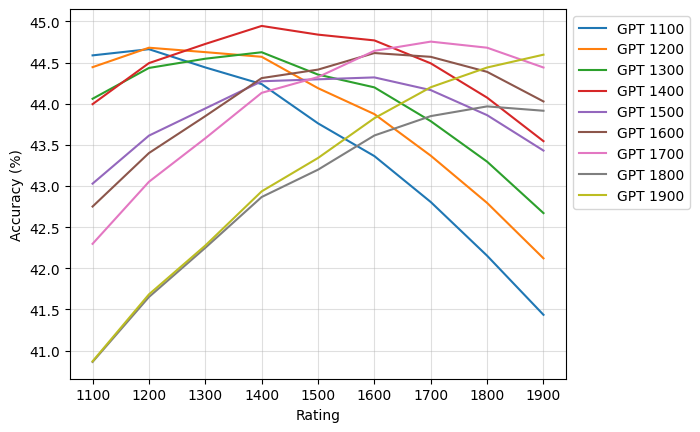

In [10]:
X = list(range(1100, 2000, 100))

for name, model_scores in scores.items():
    Y = [model_scores[f"bin_{elo}"]["test_acc"] * 100 for elo in range(1100, 2000, 100)]

    # print(f"GPT {name[-4:]}: {max(Y), min(Y)} {Y}")

    plt.plot(X, Y, label=f"GPT {name[-4:]}")

plt.xlabel("Rating")
plt.ylabel("Accuracy (%)")  # Change ylabel to include percentage
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.4)
plt.show()